In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



# Load dataset
tweets = pd.read_csv('main_data.csv')



In [15]:
tweets

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,Positive
1,1,Why is our @Conservatives government so evil?\...,Negative
2,2,"Texas Oilfield Waste Company Contributed $53,7...",Negative
3,3,Epic California snowpack is now the deepest it...,Negative
4,4,If #climatechange is real and not a hoax why d...,Negative
...,...,...,...
4405,353,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4406,354,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4407,355,['Motivation direction on how to discover # su...,Positive
4408,356,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral


In [16]:
from imblearn.over_sampling import RandomOverSampler

In [17]:
# define the oversampler
oversampler = RandomOverSampler(sampling_strategy={'Negative': 1842, 'Positive': 1822, 'Neutral': 1842})

In [18]:
# separate the features and the label
X = tweets.drop('label', axis=1)
y = tweets['label']

In [19]:
# oversample the negative class
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [20]:
# create the updated dataframe
tweets_oversampled = pd.concat([X_resampled, y_resampled], axis=1)


In [21]:
tweets_oversampled

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,Positive
1,1,Why is our @Conservatives government so evil?\...,Negative
2,2,"Texas Oilfield Waste Company Contributed $53,7...",Negative
3,3,Epic California snowpack is now the deepest it...,Negative
4,4,If #climatechange is real and not a hoax why d...,Negative
...,...,...,...
5501,141,"[""Abstemious Contamination Is Dimming Our View...",Negative
5502,3,"[""Epic California snowpack personify now the d...",Negative
5503,359,Social value covers things that impact on peop...,Negative
5504,71,['Climate variety may cut uracil forest stockt...,Negative


<Axes: xlabel='label', ylabel='count'>

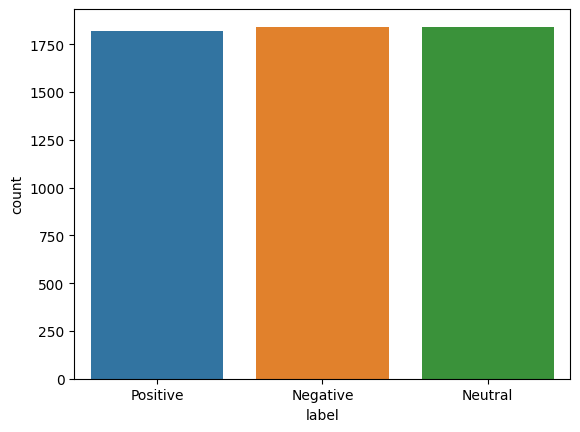

In [22]:
# Create a countplot of the labels
sns.countplot(x='label', data=tweets_oversampled)

In [23]:
# Convert labels to numeric representation
label_dict = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
tweets_oversampled['label'] = tweets_oversampled['label'].apply(lambda x: label_dict[x])


In [24]:
tweets_oversampled

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,0
1,1,Why is our @Conservatives government so evil?\...,1
2,2,"Texas Oilfield Waste Company Contributed $53,7...",1
3,3,Epic California snowpack is now the deepest it...,1
4,4,If #climatechange is real and not a hoax why d...,1
...,...,...,...
5501,141,"[""Abstemious Contamination Is Dimming Our View...",1
5502,3,"[""Epic California snowpack personify now the d...",1
5503,359,Social value covers things that impact on peop...,1
5504,71,['Climate variety may cut uracil forest stockt...,1


In [25]:
# Split dataset into train and test sets
train_df = tweets_oversampled.sample(frac=0.8, random_state=42)
test_df = tweets_oversampled.drop(train_df.index)


In [26]:
# Load tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', normalization=True)
tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f", normalization=True)
model = AutoModelForMaskedLM.from_pretrained("climatebert/distilroberta-base-climate-f",num_labels=3)
#model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

# Set device
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda')
model.to(device)


RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [27]:
# Encode the data
train_encoded_data = tokenizer.batch_encode_plus(train_df['content'].tolist(), padding=True, truncation=True, return_tensors='pt')
train_input_ids = train_encoded_data['input_ids'].to(device)
train_attention_mask = train_encoded_data['attention_mask'].to(device)
train_labels = torch.tensor(train_df['label'].tolist()).to(device)

In [28]:
test_encoded_data = tokenizer.batch_encode_plus(test_df['content'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_input_ids = test_encoded_data['input_ids'].to(device)
test_attention_mask = test_encoded_data['attention_mask'].to(device)
test_labels = torch.tensor(test_df['label'].tolist()).to(device)

# Set optimizer and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [31]:
# Train the model
epochs = 4
model.train()
batch_size = 16
for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(train_df), batch_size):
        optimizer.zero_grad()
        batch_input_ids = train_input_ids[i:i+batch_size]
        batch_attention_mask = train_attention_mask[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        print(batch_input_ids.shape)
        print(batch_attention_mask.shape)
        print(batch_labels.shape)
        outputs = model(batch_input_ids, batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_df)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")


torch.Size([16, 332])
torch.Size([16, 332])
torch.Size([16])


ValueError: Expected input batch_size (5312) to match target batch_size (16).